In [26]:
import psycopg2 #biblioteca para conectar ao banco
import pandas as pd #biblioteca para criação e gerenciamento de data frame. Também utilizada para exportar o dataframe para csv
import pandas.io.sql as sqlio #utilizado para integrar o sql com pandas, permitindo exportar os dados direto do banco para um dataframe
import matplotlib as mpl
import seaborn as sns

In [27]:
conn = psycopg2.connect(    
    database="conectcar",
    user="raul_correa", 
    password="Conect@091!",
    host="sdlf-cntcar-redshift-dev.capkkn406tig.us-east-2.redshift.amazonaws.com",
    port='5439'
)

In [28]:
LTV_month = """
DROP TABLE IF EXISTS #ltvfull;
CREATE TABLE #ltvfull (adesaoid BIGINT, detalhado VARCHAR, LTV_days INT, LTV_month INT, SafraEntrada DATE,SafraSaida DATE);
INSERT INTO #ltvfull
SELECT 
    a.adesaoid,
    c.detalhado,
    DATEDIFF (day, a.data, b.datacancelamento) as LTV_days,
    DATEDIFF (month, a.data, b.datacancelamento) as LTV_month,
    TO_DATE(a.data,'YYYY-MM-01')  as SafraEntrada,
    TO_DATE(b.datacancelamento,'YYYY-MM-01') as SafraSaida
FROM cntcar_work.tb_redshift_ciclodevida_ativacao_stage as a
LEFT JOIN cntcar_work.tb_redshift_ciclodevida_ativacao_stage as b on a.primeiraadesaoid = b.primeiraadesaoid and b.tiposaida ilike '%Cancelamento%' 
LEFT JOIN cntcar_work.tb_redshift_ciclodevida_portifolio_stage as c on a.adesaoid = c.adesaoid
    WHERE a.adesaoorigemid is null --pegando todas as novas adesões
    and LTV_days is not null -- excluindo clientes habilitados
    and SafraEntrada >= '2014-01-01'
;

DROP TABLE IF EXISTS #ltvmonth;
CREATE TABLE #ltvmonth (detalhado VARCHAR, SafraEntrada DATE, SafraSaida DATE, ltv_month INT, qtd_Adesoes INT);
INSERT INTO #ltvmonth
SELECT
detalhado,
SafraEntrada,
SafraSaida,
LTV_month,
count(adesaoid) as qtd_Adesoes
from #ltvfull
group by 1,2,3,4
order by 3 desc
;

SELECT * FROM #ltvmonth
"""

In [29]:
DADOSLTV_MONTH = sqlio.read_sql_query(LTV_month, conn) 
DADOSLTV_MONTH.columns = ['detalhado', 'safraentrada', 'safrasaida','ltv_month', 'qtd_adesoes' ]

In [30]:
print(DADOSLTV_MONTH)

             detalhado safraentrada  safrasaida  ltv_month  qtd_adesoes
0             ITAÚ TAG   2017-01-01  2020-02-01         37           12
1             ITAÚ TAG   2021-07-01  2022-10-01         15           61
2             ITAÚ TAG   2018-02-01  2019-07-01         17           40
3             ITAÚ TAG   2016-12-01  2020-07-01         43           16
4             ITAÚ TAG   2019-01-01  2020-12-01         23            5
...                ...          ...         ...        ...          ...
23623           BÁSICO   2018-08-01  2021-05-01         33            3
23624  URBANO/RODOVIAS   2019-02-01  2021-03-01         25            1
23625  PRÉ EMPRESARIAL   2014-07-01  2023-01-01        102            1
23626           BÁSICO   2018-06-01  2021-09-01         39            1
23627  PÓS EMPRESARIAL   2019-03-01  2020-05-01         14            1

[23628 rows x 5 columns]


In [20]:
DADOSLTV_MONTH.describe()

,ltv_month,qtd_adesoes
count,1118.000000,1118.000000
mean,3.956172,183.708408
std,3.118497,970.430131
min,0.000000,1.000000
25%,1.000000,5.000000
50%,3.000000,19.000000
75%,6.000000,102.750000
max,12.000000,23251.000000


<AxesSubplot:ylabel='Frequency'>

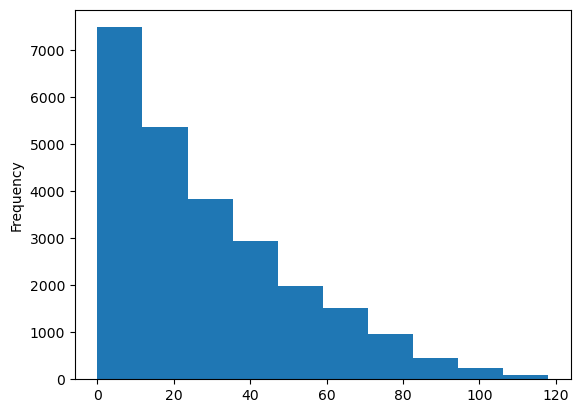

In [7]:
DADOSLTV_MONTH.ltv_month.plot(kind= 'hist')

<AxesSubplot:ylabel='ltv_month'>

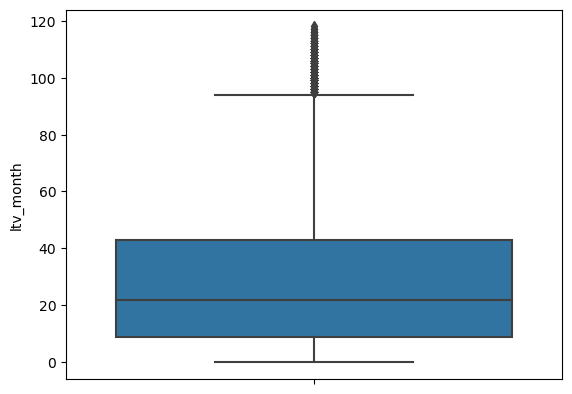

In [8]:
sns.boxplot( y =DADOSLTV_MONTH.ltv_month) #QUARTIS

c:\Users\raul.correa\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ltv_month', ylabel='Density'>

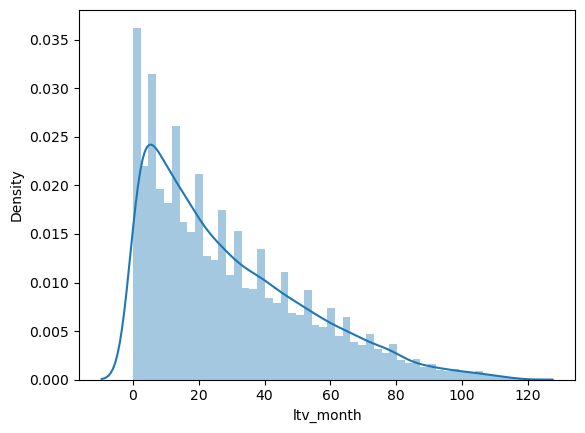

In [30]:
sns.distplot(DADOSLTV_MONTH.ltv_month)

## Analisando Completo

In [21]:
DADOSLTVCOMPLETO = DADOSLTV_MONTH[(DADOSLTV_MONTH.detalhado == "Completo" )|(DADOSLTV_MONTH.detalhado == "COMPLETO")|(DADOSLTV_MONTH.detalhado == "completo" )]
DADOSLTVCOMPLETO.head()

,detalhado,safraentrada,safrasaida,ltv_month,qtd_adesoes
10,COMPLETO,2022-06-01,2022-07-01,1,120
19,COMPLETO,2023-01-01,2023-02-01,1,171
27,COMPLETO,2022-03-01,2023-02-01,11,91
67,COMPLETO,2023-01-01,2023-03-01,2,65
74,COMPLETO,2022-08-01,2022-11-01,3,98


In [22]:
DADOSLTVCOMPLETO.describe()

,ltv_month,qtd_adesoes
count,91.000000,91.000000
mean,4.000000,85.384615
std,3.179797,35.100101
min,0.000000,6.000000
25%,1.000000,68.000000
50%,3.000000,82.000000
75%,6.000000,96.000000
max,12.000000,229.000000


In [11]:
DADOSLTVCOMPLETO.median()

C:\Users\raul.correa\AppData\Local\Temp\ipykernel_14708\1617607316.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  DADOSLTVCOMPLETO.median()


ltv_month      21.0
qtd_adesoes    59.0
dtype: float64

<AxesSubplot:ylabel='ltv_month'>

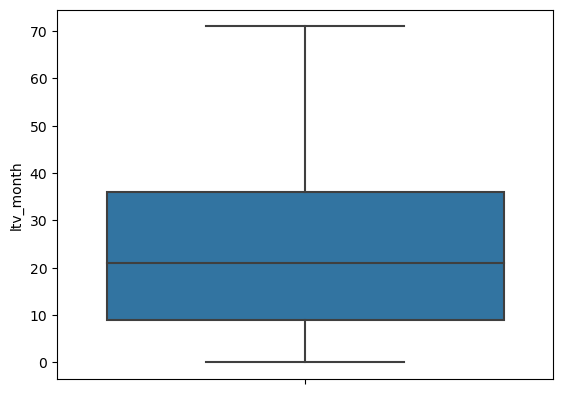

In [43]:
sns.boxplot( y =DADOSLTVCOMPLETO.ltv_month) #QUARTIS

c:\Users\raul.correa\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ltv_month', ylabel='Density'>

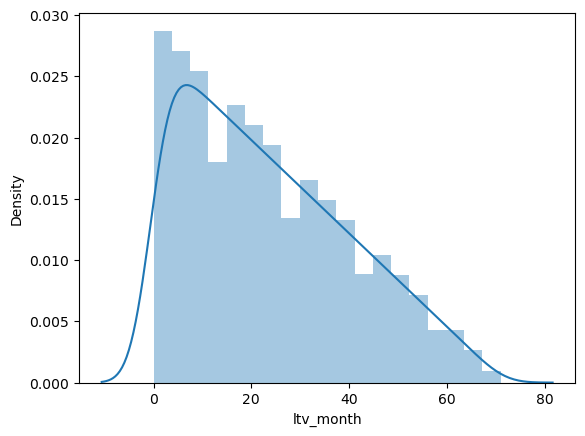

In [44]:
sns.distplot(DADOSLTVCOMPLETO.ltv_month)

## Analisando Básico

In [46]:
DADOSLTVBASICO = DADOSLTV_MONTH[(DADOSLTV_MONTH.detalhado == "Basico" )|(DADOSLTV_MONTH.detalhado == "Básico")|(DADOSLTV_MONTH.detalhado == "BÁSICO" )]
DADOSLTVBASICO.head()

,detalhado,safraentrada,safrasaida,ltv_month,qtd_adesoes
30,BÁSICO,2015-03-01,2017-08-01,29,212
31,BÁSICO,2014-11-01,2018-09-01,46,24
32,BÁSICO,2014-03-01,2017-04-01,37,17
34,BÁSICO,2014-04-01,2019-06-01,62,1515
35,BÁSICO,2016-01-01,2021-12-01,71,62


In [47]:
DADOSLTVBASICO.describe()

,ltv_month,qtd_adesoes
count,7347.000000,7347.000000
mean,39.503743,104.368722
std,28.331707,661.416843
min,0.000000,1.000000
25%,16.000000,12.000000
50%,35.000000,25.000000
75%,60.000000,50.000000
max,118.000000,21571.000000


<AxesSubplot:ylabel='ltv_month'>

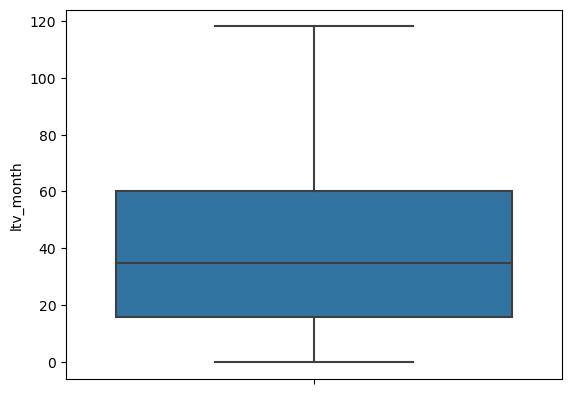

In [48]:
sns.boxplot( y =DADOSLTVBASICO.ltv_month) #QUARTIS

In [32]:
DADOSLTVITAU = DADOSLTV_MONTH[(DADOSLTV_MONTH.detalhado == "Itaú Tag" )|(DADOSLTV_MONTH.detalhado == "ITAÚ TAG")|(DADOSLTV_MONTH.detalhado == "tag itaú" )]
DADOSLTVITAU.head()

,detalhado,safraentrada,safrasaida,ltv_month,qtd_adesoes
0,ITAÚ TAG,2017-01-01,2020-02-01,37,12
1,ITAÚ TAG,2021-07-01,2022-10-01,15,61
2,ITAÚ TAG,2018-02-01,2019-07-01,17,40
3,ITAÚ TAG,2016-12-01,2020-07-01,43,16
4,ITAÚ TAG,2019-01-01,2020-12-01,23,5


In [33]:
DADOSLTVITAU.describe()

,ltv_month,qtd_adesoes
count,3428.000000,3428.000000
mean,27.143232,23.434364
std,19.924212,58.167017
min,0.000000,1.000000
25%,10.000000,4.000000
50%,23.500000,8.000000
75%,41.000000,17.000000
max,84.000000,708.000000
